# Simulated Data Exemplifying the Shrinking Overpotential Method

In [12]:
#import packages to use
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import functools
from functools import partial
import scipy.stats as st
import random
from scipy.signal import find_peaks

In [13]:
def read_DE(file):
    """
    Objective
    ----------
    To read simulated CV data from DigiElch and export voltage and current data
    Parameters
    ----------
    file : :obj:`txt file`
        a text file exported from Digielch Software containing voltage data (V) and current data (I).
    """
    file_as_text = []
    #open file and read as a csv file
    with open(file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar=',')
        for row in spamreader:
            file_as_text.extend([row])
            
    #delete header information
    file_as_text=file_as_text[2::]
    
    #make empty arrays 
    V=[]
    I=[]
    curve_data_raw = []
    curve_data_IV = []
    curve_data_raw.extend([[]]) #make empty arrays
    curve_data_IV.extend([[]])
    
    #iterate through rows and add each data point to a current and voltage array
    for row in file_as_text[0::]: 
        curve_data_raw.extend([row]) #in each column slot in a row, add index  of stuff in matrix
        curve_data_IV.extend([[float(val) for val in row[0::]]])
    
    #delete initial empty array
    curve_data=curve_data_IV[1::]
    
    #transpose so we separate voltage and current data
    curve_data=np.transpose(curve_data)
    V_sim=curve_data[0]
    I_sim=curve_data[1]*-1
    
    return V_sim, I_sim

In [14]:
#set up parameters, color pallet, and call reach_DE function
area= np.pi #cm^2 this is the simulated area
orange= '#F5793A'
purple= '#A95AA1'
lblue= '#85C0F9'
dblue='#0F2080'
gray='#899499'
black='#000000'
violet='#EE82EE'
colors=[orange, purple, lblue,dblue,gray,black,violet]
increment=0.003 #voltage the CV shrinks 
p2p_str= '/Insert_paths_to_plot_here/'
T=298#K
n=1#electron
M=1#Mol total of active material
F=96485 #Faraday's constant [coulomb/mol]
R=8.314 #J/mol-K

file='/Insert_file_path_here/ko_0.0001_SOC_50.txt'
V,I=read_DE(file)


In [15]:
def fit_ko(eta,ko,oxidation):
    """
    Objective
    ----------
    To fit current and overpotential data to the BV equation and return ko
    Parameters
    ----------
    eta : :obj:`numpy.ndarray`
        An array of overpotential values [V]
    oxidation : :obj:`numpy.float64`
        A concentration value of oxidized species [M]
    Formal : :obj: `numpy.float64`
        The formal reduction potential from this set of CV data [V]
    ko : :obj: to be fitted
        concentration of oxidized species resulting from CV Data [M]
    """
    
    A = np.pi # area in cm^2 of CF microelectrode
    Tsys = 298 #K
    Rgas = 8.314 #J/mol-K
    F = 96485 #C/mol
    alpha = 0.5
    C0 = oxidation #mol/L concentration of oxidized species
    CR = 1 - C0 #mol/L concentration of reduced species

    return -ko/1000*F*A*(C0*np.exp(-alpha*F/Rgas/Tsys*eta)-CR*np.exp((1-alpha)*F/Rgas/Tsys*eta))


In [16]:
def Solve_ko(x_data,y_data, SOC, FRP, ox, increment, guess, path_to_plots= p2p_str ):
    """
    Objective
    ----------
    Initialize parameters to fit current and overpotential data to the BV equation and plot results
    Parameters
    ----------
    x_data : :obj:`numpy.ndarray`
        An array of eta.
    y_data : :obj:`numpy.ndarray`
        An array of I.
    SOC : :obj: `numpy.float64`
        State of Charge of this set of current and overpotential data
    FRP : :obj: `numpy.float64`
        formal reduction potential
    ox : :obj: `numpy.float64`
        concentration of oxidized species resulting from CV Data
    increment: :obj: `int`
        Voltage the data shrinks by with each iteration
    path_to_plots : :obj:`str`
        local path to save pngs and gif 
    """
    T=298#K
    n=1#electron
    F=96485 #Faraday's constant [coulomb/mol]
    R=8.314 #J/mol-K
    
    #take out all cases if the mean data is nan
    x_data = [x for x in x_data if np.isnan(x) == False]
    y_data = [y for y in y_data if np.isnan(y) == False]

    #set up empty arays for results of BV fit
    ko_array = []
    max_eta = []
    sigma=[]
    iterative_eta=[]
    iterative_I=[]

    # make graphics or not
    if path_to_plots != None:
        images = []
    x_data=np.array(x_data)
    y_data=np.array(y_data)
    
    #create range of voltage values to cycle over
    #based on max V data and increment
    if abs(max(x_data)) > abs(min(x_data)):
        max_x=abs(min(x_data))
    else:
        max_x=max(x_data)
        
    max_val = round(max_x,1)
    max_val = max_val-increment/2
    #arange(start,stop,step size)
    overp_all = np.arange(start=max_val, stop=0, step=-increment)

    #iterate through x_range while decreasing overpotential
    for index in range(len(overp_all)):
        # look at all indicies in x_range
        overp = overp_all[index]
        indicies = []
        x_data_new=[]
        y_data_new=[]
        # iterate through all x_data looking for values within the defined x_range
        for i in range(len(x_data)):
            x = x_data[i]
            if abs(x) <= overp:
                #bin data
                indicies.append(i)
                x_data_new = np.append(x_data_new, x_data[i]) #put data in new array for the next cycle
                y_data_new = np.append(y_data_new, y_data[i])
                
        # make shrinking graph figure name
        if path_to_plots != None:
            figure_name = path_to_plots+str(index)+'.png'
            images.append(figure_name)
            
        # break when we run out of data to cut
        if len(y_data_new) == 0:
            break
            
        # do the BV fit
        else:
            #allows for additional arguments into the curve_fit function by redefining the fit_ko function 
            fit_ko_new= partial(fit_ko, oxidation=ox)
            #perform the non-linear least squares fit of the Butler-Volmer model using the function fit_ko
            popt, pcov = curve_fit(
                    fit_ko_new, x_data_new,y_data_new, p0=guess, maxfev=5000
                    )
            #append fitted rate constant parameter to an array
            ko_array.extend([popt[0]])
            #append other important information to arrays
            sigma.extend([np.sqrt(np.diag(pcov))])#compute one standard deviation errors on the parameters
            iterative_eta.extend([x_data_new])
            iterative_I.extend([y_data_new])
            max_eta.extend([max(abs(x_data_new))])
            
            #ability to plot ko vs eta here. Can save image here.
        
        #ability to make shrinking overpotential gif here.
    
        #ability to compile pngs into gif
        #kn.convert_images_to_gif(images, filename_final=path_to_plots+'final.gif', fps=10)
    
    #save arrays to output np arrays
    max_eta=np.array(max_eta, dtype=object)
    ko_array=np.array(ko_array, dtype=object)
    sigma=np.array(sigma, dtype=object)
    iterative_eta= np.array(iterative_eta, dtype=object)
    iterative_I= np.array(iterative_I, dtype=object)
    
    
    return max_eta, ko_array, sigma, iterative_eta, iterative_I


In [17]:
def FindSOC(V,I,SRP,T,M,s):
    """
    Objective
    ----------
    To find the SOC of the electrolyte given its current and voltage from CV

    Parameters
    ----------
    V : :obj:`numpy.ndarray`
        An array of voltage values [V]
    I : :obj:`numpy.ndarray`
        An array of current values [A]
    SRP : :obj:`numpy.float64`
        Standard reduction Potential experimentally measured of theoretically found in literature [V]
    T : :obj: `numpy.float64`
        temperature [K]
    M : :obj: `numpy.float64`
        Total molarity of active material in battery system [M]
    s : :obj: `numpy.float64`
        sensitivity of FRP (ex. 1e-9) which dictates how many indicies are averaged to find the equalibrium potential

    """
    T=298#K
    n=1#electron
    F=96485 #Faraday's constant [coulomb/mol]
    R=8.314 #J/mol-K
    FRP_range = np.where(np.abs(I)<s) #V is in V, I is in A
    print('The indicies averaged to find the equalibrium potential are:', FRP_range)
    #print(FRP_range)
    
    FRP=np.mean(V[FRP_range[0]]) #FRP is in V

    #use the nernst equation to find the FindSOC
    z=(FRP-SRP)*(F*n/(R*T)) #unitless
    p=np.exp(z) #unitless
    ox=p*M/(1+p) #solve for concentration of oxidized species#M
    SOC= ox*100/M #solve for FindSOC#%

    return SOC, FRP, ox


## plot CV at ko=1e-4 and 50% SOC

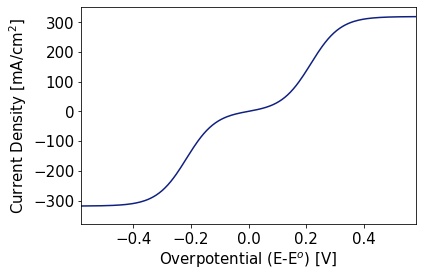

In [18]:
#find the equalibrium potential at zero SOC
#find the index of minimum current
SRP_index=np.where(abs(I)==min(abs(I)))
#find the voltage of the index of minimum current
SRP=V[SRP_index]
#convert all voltages to overpotential
eta=V-SRP

#plot CV converting current in A to mA/cm^2
#plt.rcParams.update({'font.size': 15})
plt.rcParams['svg.fonttype'] = 'none'
plt.plot(eta,I*1000/area,dblue)
plt.xlim(-.58,0.58)
plt.xlabel('Overpotential (E-E$^o$) [V]')
plt.ylabel('Current Density [mA/cm$^2$]')
plt.rcParams.update({'font.size': 13})  # increase the font size
plt.savefig(f'Fig4A.svg', bbox_inches='tight',dpi=300)


## find array of kinetic values 

In [19]:
#make current and voltage arrays into np arrays
V=np.array(V,dtype= object)
I=np.array(I,dtype= object)

#I is in A/cm^2
#I*area is in A

#call the FindSOC function with a low enough sensitivity to average ~3 indicies
SOC, FRP, ox= FindSOC(V,I,SRP,T,M,5e-3)


#define empty arrays
max_eta_array=[]
ko_array_array=[[]]
sigma_array=[]
iterative_eta_array=[]
iterative_I_array=[]

print(f'The equalibrium potential for ko=1e-4 cm/s and {SOC[0]:1.0f}% SOC is {FRP:1.3f}V')

max_eta, ko_array, sigma, iterative_eta, iterative_I= Solve_ko(eta,I, SOC, FRP, ox, increment, 1e-4, path_to_plots= p2p_str)    

The indicies averaged to find the equalibrium potential are: (array([122, 123, 124]),)
The equalibrium potential for ko=1e-4 cm/s and 50% SOC is 0.420V


/Users/Becca/.pyenv/versions/FlowCell/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Plot Butler-Volmer fitted current with raw data

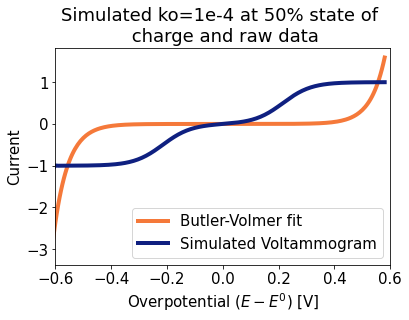

In [20]:
plt.figure()
plt.rcParams.update({'font.size': 15})

plt.plot(eta, fit_ko(eta,ko_array[0],ox), linewidth=4, markersize=14,color=orange,label=f'Butler-Volmer fit')
plt.plot(eta, I, linewidth=4, markersize=14,color=dblue,label=f'Simulated Voltammogram')
plt.xlabel('Overpotential ($E-E^0$) [V]')
plt.ylabel('Current')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlim([-0.6,0.6]) #adjusting the graph to eliminate the simulated noise at less than -0.6 V overpotential and coresponding fitted current

plt.title('Simulated ko=1e-4 at 50% state of \n charge and raw data')
plt.legend(loc='lower right')

### Plot ko vs overpotential

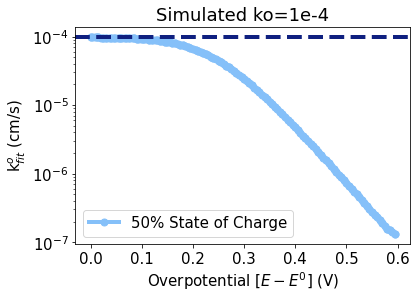

In [21]:
#plot ko vs overpotential data for 3 SOC's

plt.figure()
plt.rcParams.update({'font.size': 15})


plt.plot(max_eta, ko_array, marker= '.', linewidth=4, markersize=14,color=lblue,label=f'{SOC[0]:1.0f}% State of Charge')
plt.xlabel('Overpotential [$E-E^0$] (V)')
plt.ylabel('k$^o_{fit}$ (cm/s)')
plt.axhline(y=1e-4,color=dblue,linestyle='--',linewidth=4, markersize=10)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.yscale('log')
plt.title('Simulated ko=1e-4')
plt.legend(loc='lower left')